# Think Bayes

Second Edition

Copyright 2020 Allen B. Downey

License: [Attribution-NonCommercial-ShareAlike 4.0 International (CC BY-NC-SA 4.0)](https://creativecommons.org/licenses/by-nc-sa/4.0/)

In [4]:
# If we're running on Colab, install empiricaldist
# https://pypi.org/project/empiricaldist/

import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    !pip install empiricaldist

In [5]:
# Get utils.py and create directories

import os

if not os.path.exists('utils.py'):
    !wget https://github.com/AllenDowney/ThinkBayes2/raw/master/code/soln/utils.py
        
if not os.path.exists('figs'):
    !mkdir figs

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from empiricaldist import Pmf, Cdf
from utils import decorate, savefig

## Bayesian regression

In the previous chapter we saw several examples of logistic regression, which is based on the assumption that the likelihood of an outcome, expressed in the form of log odds, is a linear function of some measured value.

In this chapter we'll work on examples of linear regression, which models the relationship between two measured values.  Specifically, we'll look at changes over time in snowfall and the marathon world record.

The models we'll use have three parameters, so you might want to review the tools we used for the three-parameter model in Chapter 13.

## More snow?

I am under the impression that we don't get as much snow around here as we used to.  By "around here" I mean Norfolk County, Massachusetts, where I was born, grew up, and currently live.  And by "used to" I mean compared to when I was young, like in 1978 when we got [27 inches of snow](https://en.wikipedia.org/wiki/Northeastern_United_States_blizzard_of_1978) and I didn't have to go to school for a couple of weeks.

Fortunately, we can test my conjecture with data.  Norfolk County happens to be the location of the [Blue Hill Meteorological Observatory](https://en.wikipedia.org/wiki/Blue_Hill_Meteorological_Observatory), which keeps the oldest continuous weather record in North America.

Data from this and many other weather stations is available from the [National Oceanic and Atmospheric Administration](https://www.ncdc.noaa.gov/cdo-web/search) (NOAA).  I collected data from the Blue Hill Observatory from May 11, 1967 to May 11, 2020.  The following cell downloads the data as a CSV file.

In [7]:
import os

datafile = '2239075.csv'
if not os.path.exists(datafile):
    !wget https://github.com/AllenDowney/ThinkBayes2/raw/master/data/2239075.csv

We can read the data into a Pandas `DataFrame`:

In [8]:
df = pd.read_csv('2239075.csv', parse_dates=[2])

Here's what the last few rows look like.

In [9]:
df.tail()

,STATION,NAME,DATE,PRCP,SNOW,SNWD,TMAX,TMIN,TOBS,WESD,WT01,WT03,WT04,WT05,WT06,WT08,WT09,WT11,WT16,WT18
19355,USC00190736,"BLUE HILL COOP, MA US",2020-05-07,0.00,0.0,0.0,57,37.0,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19356,USC00190736,"BLUE HILL COOP, MA US",2020-05-08,0.00,0.0,0.0,63,42.0,45.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19357,USC00190736,"BLUE HILL COOP, MA US",2020-05-09,0.45,0.0,0.0,57,34.0,34.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19358,USC00190736,"BLUE HILL COOP, MA US",2020-05-10,0.00,0.0,0.0,44,31.0,38.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19359,USC00190736,"BLUE HILL COOP, MA US",2020-05-11,0.00,0.0,0.0,59,38.0,50.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


I'll add a column that contains just the year part of the dates.

In [10]:
df['YEAR'] = df['DATE'].dt.year

And use `groupby` to add up the total snowfall in each year.

In [11]:
snow = df.groupby('YEAR')['SNOW'].sum()
len(snow)

54

The first and last years are not complete, so I'll drop them.

In [12]:
complete = snow.iloc[1:-1]
len(complete)

52

The following figure shows total snowfall during each of the complete years in my lifetime.

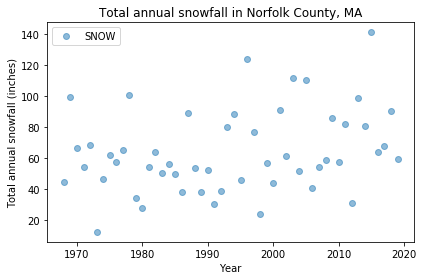

In [13]:
complete.plot(style='o', alpha=0.5)

decorate(xlabel='Year',
         ylabel='Total annual snowfall (inches)',
         title='Total annual snowfall in Norfolk County, MA')

Looking at this plot, it's hard to say whether snowfall is increasing, decreasing, or unchanged.  In the last decade, we've had several years with more snow than 1978, including 2015, which was the snowiest winter in the Boston area in modern history, with a total of 141 inches.

In [14]:
complete.loc[[1978, 1996, 2015]]

YEAR
1978    100.6
1996    124.2
2015    141.1
Name: SNOW, dtype: float64

This kind of question -- looking at noisy data and wondering whether it is going up or down -- is precisely the question we can answer with Bayesian regression.

## Regression model

The foundation of regression (Bayesian or not) is the model that a time series like this is the sum of two parts:

1. A linear function of time, and

2. A series of random values drawn from a distribution that is not changing over time.

Mathematically,

$y = a x + b + \epsilon$

where $y$ is the series of measurements (snowfall in this example), $x$ is the series of times (years) and $\epsilon$ is the series of random values.

$a$ and $b$ are the slope and intercept of the line through the data.  They are unknown parameters, so we will use the data to estimate them.

We don't know the distribution of $\epsilon$, so we'll make the additional assumption that it is a normal distribution with mean 0 and unknown standard deviation, $\sigma$.  

To see whether this assumption is reasonable, I'll plot the distribution of total snowfall and a normal model with the same mean and standard deviations.  

In [15]:
pmf_snowfall = Pmf.from_seq(complete)

mean, std = pmf_snowfall.mean(), pmf_snowfall.std()
mean, std

(64.19038461538462, 26.288021984395684)

In [16]:
from scipy.stats import norm

dist = norm(mean, std)
qs = pmf_snowfall.qs
ps = dist.cdf(qs)

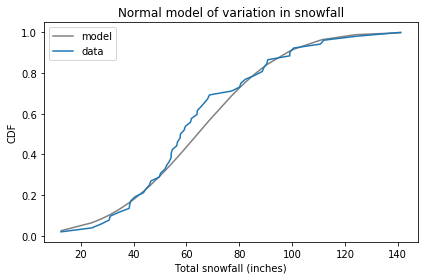

In [17]:
plt.plot(qs, ps, color='gray', label='model')
pmf_snowfall.make_cdf().plot(label='data')

decorate(xlabel='Total snowfall (inches)',
         ylabel='CDF',
         title='Normal model of variation in snowfall')

We've had more winters below the mean than expected, but overall this looks like a reasonable model, particularly in the tails, which are often problematic.

This model has three parameters: slope, intercept, and standard deviation of $\epsilon$.  In the next section we'll see how to compute the likelihood of the data, given these parameters; then we'll see how to estimate them.


## Ordinary least squares

Before we get to Bayesian regression, I'll use StatsModel to fit a line to the data by [least squares regression](https://en.wikipedia.org/wiki/Least_squares).

To prepare the data, I'll use `reset_index` to convert `complete`, which is a `Series`, to a `DataFrame`.

In [18]:
data = complete.reset_index()
data.head()

,YEAR,SNOW
0,1968,44.7
1,1969,99.2
2,1970,66.8
3,1971,54.6
4,1972,68.7


The result is a `DataFrame` with two columns: the index and values from `complete`.  The index of the new `DataFrame` is a range of integers starting from 0.

As we did in the previous chapter, I'll center the data by subtracting off the mean.

In [19]:
offset = data['YEAR'].mean()
offset

1993.5

In [20]:
data['x'] = data['YEAR'] - offset
data['x'].mean()

0.0

And I'll add a column to `data` just so the dependent variable has a standard name.

In [21]:
data['y'] = data['SNOW']

Now we can use StatsModels to estimate the parameters.

In [22]:
import statsmodels.formula.api as smf

formula = 'y ~ x'
results = smf.ols(formula, data=data).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.085
Model:                            OLS   Adj. R-squared:                  0.067
Method:                 Least Squares   F-statistic:                     4.669
Date:                Mon, 17 Aug 2020   Prob (F-statistic):             0.0355
Time:                        14:29:13   Log-Likelihood:                -241.46
No. Observations:                  52   AIC:                             486.9
Df Residuals:                      50   BIC:                             490.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     64.1904      3.555     18.054      0.000      57.049      71.332
x              0.5119      0.237      2.161      0.036       0.036       0.988
==============================================================================
Omnibus:                        3.736   Durbin-Watson:                   2.290
Prob(Omnibus):                  0.154   Jarque-Bera (JB):                3.257
Skew:                           0.613   Prob(JB):                        0.196
Kurtosis:                       2.978   Cond. No.                         15.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

According to this model, total snowfall is increasing at a rate of about 0.5 inches per year.  As the next step toward Bayesian regression, I'll compute the likelihood of the data with these parameters.

## Likelihood

Here are approximate values for the slope, intercept, and standard deviation of the data.

In [23]:
inter = 64
slope = 0.51
sigma = 26

I'll extract the `xs` and `ys` as `Series` objects:

In [24]:
xs = data['x']
ys = data['y']

And compute the "residuals", which are the differences between the actual values, `ys`, and the values we expect based on `slope` and `inter`.

In [25]:
expected = slope * xs + inter
resid = ys - expected
resid.describe()

count    52.000000
mean      0.190385
std      25.385697
min     -42.335000
25%     -17.442500
50%      -6.565000
75%      14.125000
max      66.135000
dtype: float64

According to the model, the residuals should follow a normal distribution with mean 0 and standard deviation `sigma`.  We can compute the likelihood of each residual value using `norm` from `SciPy`.

In [26]:
densities = norm(0, sigma).pdf(resid)
densities

array([0.01490073, 0.00285242, 0.01305324, 0.01529515, 0.01279708,
       0.0044134 , 0.01470964, 0.01474532, 0.01526593, 0.01426784,
       0.00354561, 0.010655  , 0.00809097, 0.01521138, 0.01494539,
       0.01455552, 0.01525171, 0.01425735, 0.01077026, 0.00837361,
       0.01468642, 0.01030307, 0.01430933, 0.00718604, 0.00993735,
       0.01258966, 0.0098625 , 0.01182567, 0.00117652, 0.0139576 ,
       0.00411173, 0.01420639, 0.01015782, 0.01038433, 0.01482279,
       0.00386994, 0.01221638, 0.00446989, 0.00796445, 0.01248853,
       0.01372076, 0.01330202, 0.01304467, 0.01437819, 0.00407589,
       0.00960892, 0.01492131, 0.00060389, 0.01392   , 0.01463711,
       0.01329929, 0.01226386])

The result is an array of PDFs.  The likelihood of the data is the product of the values in this array.

In [27]:
likelihood = densities.prod()
likelihood

1.290411849292259e-105

As we saw in the previous chapter, the likelihood of any particular dataset tends to be very small.  If it gets to be too small, we might reach the limits of floating-point arithmetic.  When that happens, we can avoid the problem by computing likelihoods under a log transform.  But in this example that's not necessary.

## Priors

Now that we have figured out the likelihood function, all we need is a prior distribution.

I'll use uniform distributions for all three parameters, using the values we estimated with StatsModels as a starting place.

In [28]:
slopes = np.linspace(-0.5, 1.5, 51)
prior_slope = Pmf(1, slopes)
prior_slope.index.name = 'Slope'

In [29]:
inters = np.linspace(55, 75, 41)
prior_inter = Pmf(1, inters)
prior_inter.index.name = 'Intercept'

In [30]:
sigmas = np.linspace(20, 35, 31)
prior_sigma = Pmf(1, sigmas)
prior_sigma.index.name = 'Sigma'

I made the prior distributions different lengths for two reasons.  First, if I make a mistake and use the wrong distribution, it will be easier to catch the error if they are all different lengths.

Second, it allows me to get more precision for the most important parameter for our purposes, `slope`, and spend less computational effort on the least important, `sigma`.

In Chapter 13 made a joint distribution with three parameters.  I'll wrap that process in a function:

In [31]:
from utils import make_joint

def make_joint3(pmf1, pmf2, pmf3):
    """Make a joint distribution with three parameters.
    
    pmf1: Pmf object
    pmf2: Pmf object
    pmf3: Pmf object
    
    returns: Pmf representing a joint distribution
    """
    joint2 = make_joint(pmf2, pmf1).stack()
    joint3 = make_joint(pmf3, joint2).stack()
    return Pmf(joint3)

In [32]:
prior3 = make_joint3(prior_slope, prior_inter, prior_sigma)
prior3.head()

Slope  Intercept  Sigma
-0.5   55.0       20.0     1
                  20.5     1
                  21.0     1
                  21.5     1
                  22.0     1
dtype: int64

The result is a `Pmf` that represents the joint prior distribution of the three parameters.
Its index has three columns, containing values of `slope`, `inter`, and `sigma`, in that order.

With three parameters, the size of the joing distribution starts to get big.  Specifically, it is the product of the lengths of the prior distributions.  In this example, the prior distributions have 51, 41, and 31 values, so the length of the joint prior is 64,821.

In [33]:
len(prior_slope), len(prior_inter), len(prior_sigma)

(51, 41, 31)

In [34]:
len(prior_slope) * len(prior_inter) * len(prior_sigma)

64821

In [35]:
len(prior3)

64821

## The Update

Now we're ready to do a Bayesian update.  First, we need to compute the likelihood of the data for each possible set of parameters.

The following function takes the joint prior distribution and the data, computes the likelihoods, and returns the posterior distribution.

In [36]:
def update_regression(prior, data):
    """
    """
    xs = data['x']
    ys = data['y']
    likelihood = prior.copy()

    for slope, inter, sigma in prior.index:
        expected = slope * xs + inter
        resid = ys - expected
        densities = norm.pdf(resid, 0, sigma)
        likelihood.loc[slope, inter, sigma] = densities.prod()
        
    posterior = prior * likelihood
    posterior.normalize()
    return posterior

With three parameters, it takes a while to run.

In [37]:
%time posterior = update_regression(prior3, data)
posterior.head()

CPU times: user 49.2 s, sys: 1.86 ms, total: 49.2 s
Wall time: 49.2 s


Slope  Intercept  Sigma
-0.5   55.0       20.0     1.565905e-14
                  20.5     8.422792e-14
                  21.0     3.790194e-13
                  21.5     1.452473e-12
                  22.0     4.815338e-12
dtype: float64

This function takes some time to run; in the next section we'll see a way to speed it up.

The result is a `Pmf` with a three-level index containing values of `slope`, `inter`, and `sigma`.

In the next section we'll extract the marginal posterior distributions for the three parameters.

## Unpacking the Marginals

To get the marginal distributions from the posterior, we can use `pmf_marginal`, which we saw in Chapter 13.

Here's the posterior distribution for `sigma`:

The result is a `DataFrame` with `slope` and `inter` down the rows and `sigma` across the columns.  So we can use `marginal` to get the posterior distribution of `sigma`.

In [41]:
from utils import pmf_marginal

posterior_sigma = pmf_marginal(posterior, 2)

The result is a `Pmf` that contains possible values of `sigma` and their probabilities.

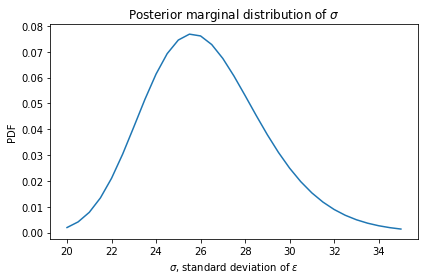

In [42]:
posterior_sigma.plot()

decorate(xlabel='$\sigma$, standard deviation of $\epsilon$',
         ylabel='PDF',
         title='Posterior marginal distribution of $\sigma$')

The most likely values for `sigma` are near 26 inches, which is consistent with our estimate based on the standard deviation of the data.

However, to say whether snowfall is increasing or decreasing, we don't really care about `sigma`.  It is a "nuisance parameter", so-called because we have to estimate it as part of the model, but we don't need it to answer the questions we are interested in.

Nevertheless, it is good to check the marginal distributions to make sure 

* The location and shape are consistent with our expectations, and 

* The posterior probabilities drop to near 0 at the extremes of the range, which indicates that the prior distribution covered all values with non-negligible probability.

In this example, the posterior distribution of `sigma` looks fine.

We can use `pmf_marginal` to get the other two marginal distributions.

In [43]:
posterior_slope = pmf_marginal(posterior, 0)
posterior_inter = pmf_marginal(posterior, 1)

Here's the posterior distribution of `inter`:

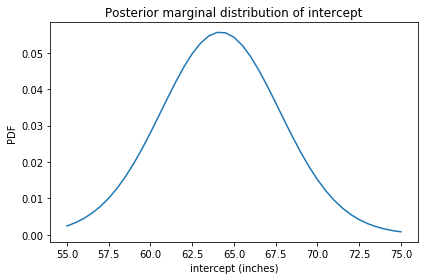

In [44]:
posterior_inter.plot()
decorate(xlabel='intercept (inches)',
         ylabel='PDF',
         title='Posterior marginal distribution of intercept')

In [45]:
posterior_inter.mean(), posterior_inter.credible_interval(0.9)

(64.23067760617819, array([58.5, 70. ]))

In [46]:
offset

1993.5

The posterior mean is about 64 inches, which the expected amount of snow during the year at the midpoint of the range, 1993.

And finally, here's the posterior distribution of `slope`:

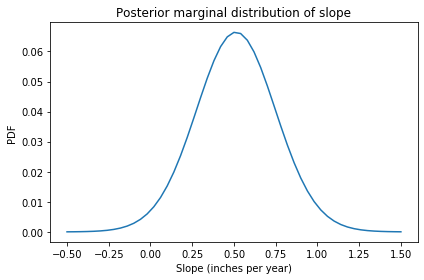

In [47]:
posterior_slope.plot()
decorate(xlabel='Slope (inches per year)',
         ylabel='PDF',
         title='Posterior marginal distribution of slope')

In [48]:
posterior_slope.mean(), posterior_slope.credible_interval(0.9)

(0.5118660811960728, array([0.1, 0.9]))

The posterior mean is about 0.51 inches, which is consistent with the estimate we got from least squared regression.  

The 90% credible interval is from 0.1 to 0.9, which indicates that our uncertainty about this estimate is pretty high.  In fact, there is still a small posterior probability (about 2\%) that the slope is negative. 

In [49]:
posterior_slope.make_cdf()(0)

array(0.01839056)

However, it is more likely that my conjecture was wrong: we are actually getting more snow around here than we used to, increasing at a rate of about a half-inch per year, which is substantial.  On average, we get an additional 25 inches of snow per year than we did when I was young.

This example shows that with slow-moving trends and noisy data, your instincts can be misleading.  

Now, you might suspect that I overestimate the amount of snow when I was young because I enjoyed it, and underestimate it now because I don't.  But you would be mistaken.

During the Blizzard of 1978, we did not have a snowblower and my brother and I had to shovel.  My sister got a pass for no good reason.  Our driveway was about 60 feet long and three cars wide near the garage.  And we had to shovel Mr. Crocker's driveway, too, for which we were not allowed to accept payment.  Furthermore, as I recall it was during this excavation that I accidentally hit my brother with a shovel on the head, and it bled a lot because, you know, scalp wounds.

Anyway, the point is that I don't think I overestimate the amount of snow when I was young because I have fond memories of it. 

## Optimization

The way we computed the likelihood in the previous section was pretty slow.  The problem is that we looped through every possible set of parameters in the prior distribution, and there were more than 60,000 of them.

If we can do more work per iteration, and run the loop fewer times, we expect it to go faster.

In order to do that, I'll unstack the prior distribution:

In [50]:
joint3 = prior3.unstack()
joint3.head()

Sigma            20.0  20.5  21.0  21.5  22.0  22.5  23.0  23.5  24.0  24.5  \
Slope Intercept                                                               
-0.5  55.0          1     1     1     1     1     1     1     1     1     1   
      55.5          1     1     1     1     1     1     1     1     1     1   
      56.0          1     1     1     1     1     1     1     1     1     1   
      56.5          1     1     1     1     1     1     1     1     1     1   
      57.0          1     1     1     1     1     1     1     1     1     1   

Sigma            ...  30.5  31.0  31.5  32.0  32.5  33.0  33.5  34.0  34.5  \
Slope Intercept  ...                                                         
-0.5  55.0       ...     1     1     1     1     1     1     1     1     1   
      55.5       ...     1     1     1     1     1     1     1     1     1   
      56.0       ...     1     1     1     1     1     1     1     1     1   
      56.5       ...     1     1     1     1     1     1     1     1     1   
      57.0       ...     1     1     1     1     1     1     1     1     1   

Sigma            35.0  
Slope Intercept        
-0.5  55.0          1  
      55.5          1  
      56.0          1  
      56.5          1  
      57.0          1  

[5 rows x 31 columns]

The result is a `DataFrame` with `slope` and `intercept` down the rows and `sigmas` across the 

The following is a version of `likelihood_regression` that takes the joint prior distribution in this form and returns the posterior distribution in the same form.

In [113]:
from utils import normalize

def update_optimized(prior, data):
    """
    """
    xs = data['x']
    ys = data['y']
    sigmas = prior.columns    
    likelihood = prior.copy()

    for slope, inter in prior.index:
        expected = slope * xs + inter
        resid = ys - expected
        resid_mesh, sigma_mesh = np.meshgrid(resid, sigmas)
        densities = norm.pdf(resid_mesh, 0, sigma_mesh)
        likelihood.loc[slope, inter] = densities.prod(axis=1)
        
    posterior = prior * likelihood
    normalize(posterior)
    return posterior

This version loops through all possible pairs of `slope` and `inter`, so the loop runs about 2000 times.

In [55]:
len(prior_slope) * len(prior_inter)

2091

Each time through the loop, it uses a grid mesh to compute the likelihood of the data for all values of `sigma`.  The result is an array with one column for each data point and one row for each value of `sigma`.  Taking the product across the columns (`axis=1`) yields the probability of the data for each value of sigma, which we assign as a row in `likelihood`.

In [56]:
%time posterior_opt = update_optimized(joint3, data)

CPU times: user 2.06 s, sys: 7.93 ms, total: 2.06 s
Wall time: 2.06 s


We get the same result either way.

In [57]:
max(abs(posterior - posterior_opt.stack()))

0.0

But this version is about 25 times faster than the previous version.  

This optimization works because many functions in NumPy and SciPy are written in C, so they run fast compared to Python.  If you can do more work each time you call these functions, and less time running the loop in Python, your code will often run substantially faster.

In this version of the posterior distribution, `slope` and `inter` run down the rows and `sigma` runs across the columns.  So we can use `marginal` to get the posterior joint distribution of `slope` and `intercept`.

In [66]:
posterior2 = marginal(posterior_opt, 1)
posterior2.head(2)

Slope  Intercept
-0.5   55.0         1.088531e-07
       55.5         1.400255e-07
       56.0         1.778945e-07
       56.5         2.231539e-07
       57.0         2.763324e-07
dtype: float64

The result is a `Pmf` with two columns in the index.
To plot it, we have to unstack it.

In [67]:
joint_posterior = posterior2.unstack().transpose()
joint_posterior.head(2)

Slope,-0.50,-0.46,-0.42,-0.38,-0.34,-0.30,-0.26,-0.22,-0.18,-0.14,...,1.14,1.18,1.22,1.26,1.30,1.34,1.38,1.42,1.46,1.50
Intercept,,,,,,,,,,,,,,,,,,,,,
55.0,1.088531e-07,1.804076e-07,2.949886e-07,4.756651e-07,7.560171e-07,0.000001,0.000002,0.000003,0.000004,0.000006,...,0.000008,0.000005,0.000004,0.000002,0.000002,9.885575e-07,6.274826e-07,3.924648e-07,2.420038e-07,1.471870e-07
55.5,1.400255e-07,2.329079e-07,3.822384e-07,6.186706e-07,9.870532e-07,0.000002,0.000002,0.000004,0.000005,0.000008,...,0.000010,0.000007,0.000005,0.000003,0.000002,1.293595e-06,8.179717e-07,5.096762e-07,3.131106e-07,1.897402e-07
56.0,1.778945e-07,2.969361e-07,4.890710e-07,7.944823e-07,1.272252e-06,0.000002,0.000003,0.000005,0.000007,0.000011,...,0.000013,0.000009,0.000006,0.000004,0.000003,1.671061e-06,1.052728e-06,6.535394e-07,4.000356e-07,2.415544e-07
56.5,2.231539e-07,3.737507e-07,6.177343e-07,1.007052e-06,1.618446e-06,0.000003,0.000004,0.000006,0.000009,0.000014,...,0.000017,0.000012,0.000008,0.000005,0.000003,2.130337e-06,1.337233e-06,8.272033e-07,5.045584e-07,3.036196e-07
57.0,2.763324e-07,4.643366e-07,7.700312e-07,1.259621e-06,2.031355e-06,0.000003,0.000005,0.000008,0.000012,0.000017,...,0.000022,0.000015,0.000010,0.000007,0.000004,2.679369e-06,1.676039e-06,1.033228e-06,6.280924e-07,3.767026e-07


Here's what it looks like.

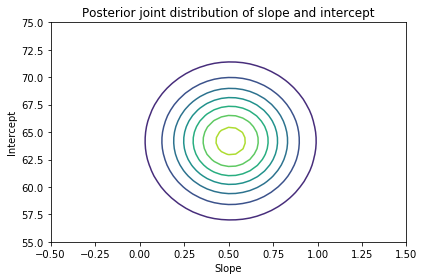

In [68]:
from utils import plot_contour

plot_contour(joint_posterior)
decorate(title='Posterior joint distribution of slope and intercept')

The ovals in the contour plot are aligned with the axes, which indicates that there is no correlation between `slope` and `inter` in the posterior distribution, which is what we expect since we centered the values.

In this example, the motivating question is about the slope of the line, so we can answer it by looking at the posterior distribution for one of the parameters.

The next example involved prediction, so we'll see how to use the joint posterior distribution to generate predictive distributions.

## Empirical Bayes

TODO: Move this to Chapter 14

## Marathon world record

For many running events, if you plot the world record pace over time, the result is a remarkably straight line.  People have speculated about possible reasons for this phenomenon, [including me](http://allendowney.blogspot.com/2011/04/two-hour-marathon-in-2045.html).

People have also speculated about when, if ever, the world record time for the marathon will be less than two hours.
(Note: In 2019 Eliud Kipchoge ran the marathon distance in under two hours, which is an astonishing achievement that I fully appreciate, but for several reasons it did not count as a world record).

So, as a second example of Bayesian regression, we'll consider the world record progression for the marathon (for male runners), estimate the parameters of a linear model, and use the model to predict when a runner will break the two-hour barrier.  

The following cell downloads a web page from Wikipedia that includes a table of Marathon world records and uses Pandas to put the data in a `DataFrame`.

In [69]:
url = 'https://en.wikipedia.org/wiki/Marathon_world_record_progression#Men'
tables = pd.read_html(url)
len(tables)

5

If that doesn't work, I have made a copy of this page available.  The following cell downloads and parses it.

In [70]:
#import os

#datafile = 'Marathon_world_record_progression.html'
#if not os.path.exists(datafile):
#    !wget https://github.com/AllenDowney/ThinkBayes2/raw/master/data/Marathon_world_record_progression.html

#tables = pd.read_html(datafile)
#len(tables)

Either way, it's the first table we want.

In [71]:
table = tables[0]
table.head()

,Time,Name,Nationality,Date,Event/Place,Source,Notes
0,2:55:18.4,Johnny Hayes,United States,"July 24, 1908","London, United Kingdom",IAAF[53],Time was officially recorded as 2:55:18 2/5.[5...
1,2:52:45.4,Robert Fowler,United States,"January 1, 1909","Yonkers,[nb 5] United States",IAAF[53],Note.[56]
2,2:46:52.8,James Clark,United States,"February 12, 1909","New York City, United States",IAAF[53],Note.[56]
3,2:46:04.6,Albert Raines,United States,"May 8, 1909","New York City, United States",IAAF[53],Note.[56]
4,2:42:31.0,Henry Barrett,United Kingdom,"May 26, 1909[nb 6]","Polytechnic Marathon, London, United Kingdom",IAAF[53],Note.[56]


We can use Pandas to parse the dates.  A couple of them include notes that could cause errors, but the argment `errors='coerce'` tells Pandas to fill invalid dates with `NaT`, which is a version of `NaN` that represents "not a time". 

In [72]:
table['date'] = pd.to_datetime(table['Date'], errors='coerce')
table['date'].head()

0   1908-07-24
1   1909-01-01
2   1909-02-12
3   1909-05-08
4          NaT
Name: date, dtype: datetime64[ns]

We can also use Pandas to parse the record times.

In [73]:
table['time'] = pd.to_timedelta(table['Time'])

And convert the times to paces in miles per hour.

In [83]:
table['y'] = 26.2 / table['time'].dt.total_seconds() * 3600
table['y'].head()

0    8.967143
1    9.099504
2    9.419942
3    9.465508
4    9.672854
Name: y, dtype: float64

The following function plots the results.

In [84]:
def plot_speeds(df):
    """Plot marathon world record speed as a function of time.
    
    df: DataFrame with date and mph
    """
    plt.axhline(13.1, color='gray')
    plt.plot(df['date'], df['mph'], 'o', alpha=0.5)
    
    decorate(xlabel='Date',
             ylabel='Speed (mph)')

And here's what it looks like.

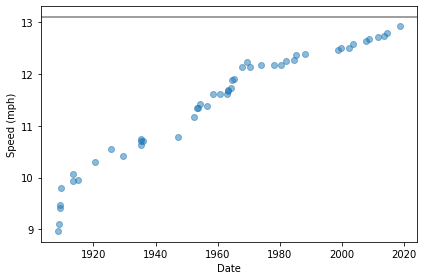

In [85]:
plot_speeds(table)

It's not a perfectly straight line.  In the early years of the marathon, the record pace increased quickly.  Since about 1970, it has been increasing more slowly.

For our analysis, let's focus on the recent progression, starting in 1970.

In [86]:
recent = table['date'] > pd.to_datetime('1970')

Here's what that looks like.

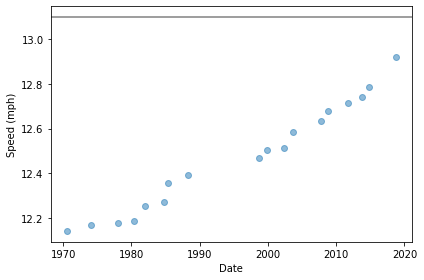

In [87]:
data = table.loc[recent].copy()
plot_speeds(data)

That seems like a straighter line, although it's possible that the slope is increasing.

To prepare the data for regression, I'll subtract away the approximate midpoint of the time interval, 1995.

In [88]:
offset = pd.to_datetime('1995')
timedelta = table['date'] - offset

And convert the time differences to floating-point numbers in years.

In [89]:
data['x'] = timedelta.dt.total_seconds() / 3600 / 24 / 365.24
data['x'].describe()

count    18.000000
mean      0.740913
std      15.417918
min     -24.444201
25%     -12.352152
50%       4.264319
75%      13.492498
max      23.707699
Name: x, dtype: float64

As in the previous example, I'll use ordinary least squares to generate point estimates for the parameters, which will help with choosing priors.

In [90]:
import statsmodels.formula.api as smf

formula = 'y ~ x'
results = smf.ols(formula, data=data).fit()
results.summary()

/home/downey/anaconda3/envs/ThinkBayes2/lib/python3.7/site-packages/scipy/stats/stats.py:1535: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=18
  "anyway, n=%i" % int(n))


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.971
Model:                            OLS   Adj. R-squared:                  0.969
Method:                 Least Squares   F-statistic:                     530.7
Date:                Mon, 17 Aug 2020   Prob (F-statistic):           1.07e-13
Time:                        14:59:36   Log-Likelihood:                 32.294
No. Observations:                  18   AIC:                            -60.59
Df Residuals:                      16   BIC:                            -58.81
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     12.4605      0.010   1237.317      0.000      12.439      12.482
x              0.0155      0.001     23.037      0.000       0.014       0.017
==============================================================================
Omnibus:                        1.748   Durbin-Watson:                   1.101
Prob(Omnibus):                  0.417   Jarque-Bera (JB):                1.174
Skew:                           0.612   Prob(JB):                        0.556
Kurtosis:                       2.745   Cond. No.                         15.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

If you get a warning about a kurtosis test, you can ignore it.  

The estimated intercept is about 12.5 mph, which is the expected world record pace in 1995.  The estimated slope is about 0.016 mph per year, which is rate the world record pace is increasing, according to the model.

These parameters give us a good idea where we should put the prior distributions.

## The priors

In [105]:
slopes = np.linspace(0.012, 0.018, 51)
prior_slope = Pmf(1, slopes)
prior_slope.index.name = 'Slope'

In [106]:
inters = np.linspace(12.4, 12.5, 41)
prior_inter = Pmf(1, inters)
prior_inter.index.name = 'Intercept'

In [107]:
sigmas = np.linspace(0.01, 0.21, 31)
prior_sigma = Pmf(1, sigmas)
prior_sigma.index.name = 'Sigma'

In [108]:
joint3 = make_joint3(prior_slope, prior_inter, prior_sigma)
joint3.head()

Slope  Intercept  Sigma   
0.012  12.4       0.010000    1
                  0.016667    1
                  0.023333    1
                  0.030000    1
                  0.036667    1
dtype: int64

In [109]:
prior = joint3.unstack()
prior.head()

Sigma            0.010000  0.016667  0.023333  0.030000  0.036667  0.043333  \
Slope Intercept                                                               
0.012 12.4000           1         1         1         1         1         1   
      12.4025           1         1         1         1         1         1   
      12.4050           1         1         1         1         1         1   
      12.4075           1         1         1         1         1         1   
      12.4100           1         1         1         1         1         1   

Sigma            0.050000  0.056667  0.063333  0.070000  ...  0.150000  \
Slope Intercept                                          ...             
0.012 12.4000           1         1         1         1  ...         1   
      12.4025           1         1         1         1  ...         1   
      12.4050           1         1         1         1  ...         1   
      12.4075           1         1         1         1  ...         1   
      12.4100           1         1         1         1  ...         1   

Sigma            0.156667  0.163333  0.170000  0.176667  0.183333  0.190000  \
Slope Intercept                                                               
0.012 12.4000           1         1         1         1         1         1   
      12.4025           1         1         1         1         1         1   
      12.4050           1         1         1         1         1         1   
      12.4075           1         1         1         1         1         1   
      12.4100           1         1         1         1         1         1   

Sigma            0.196667  0.203333  0.210000  
Slope Intercept                                
0.012 12.4000           1         1         1  
      12.4025           1         1         1  
      12.4050           1         1         1  
      12.4075           1         1         1  
      12.4100           1         1         1  

[5 rows x 31 columns]

In [114]:
posterior = update_optimized(prior, data)

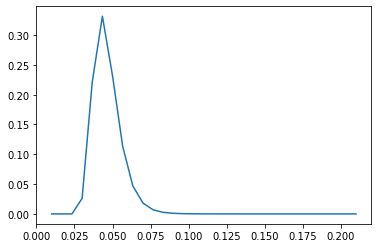

In [115]:
from utils import marginal

posterior_sigma = marginal(posterior, 0)
posterior_sigma.plot()

In [116]:
posterior_pmf = marginal(posterior, 1)
posterior_pmf.shape

(2091,)

In [117]:
posterior_joint = posterior_pmf.unstack().transpose()
posterior_joint.shape

(41, 51)

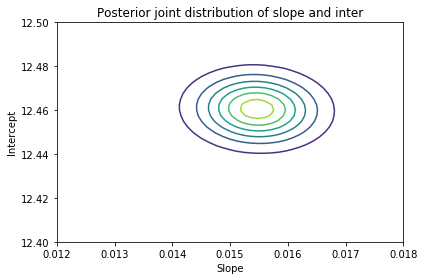

In [120]:
plot_contour(posterior_joint)
decorate(title='Posterior joint distribution of slope and inter')

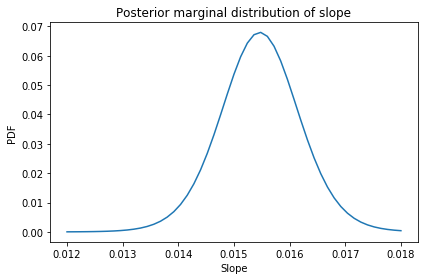

In [121]:
posterior_slope = marginal(posterior_joint, 0)

posterior_slope.plot()
decorate(xlabel='Slope',
         ylabel='PDF',
         title='Posterior marginal distribution of slope')

In [122]:
posterior_slope.mean(), posterior_slope.credible_interval(0.9)

(0.01546191796847868, array([0.01428, 0.01668]))

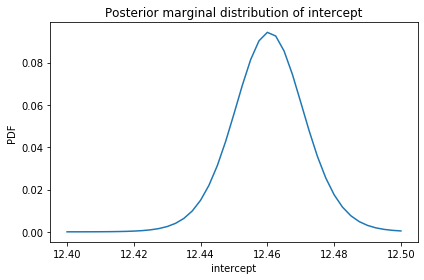

In [123]:
posterior_inter = marginal(posterior_joint, 1)

posterior_inter.plot()
decorate(xlabel='intercept',
         ylabel='PDF',
         title='Posterior marginal distribution of intercept')

In [124]:
posterior_inter.mean(), posterior_inter.credible_interval(0.9)

(12.460478647183038, array([12.4425, 12.4775]))

## Prediction

In [126]:
posterior_pmf = Pmf(posterior.stack())
posterior_pmf.head()

Slope  Intercept  Sigma   
0.012  12.4       0.010000    1.262529e-312
                  0.016667    3.343049e-109
                  0.023333     1.094238e-54
                  0.030000     3.900183e-33
                  0.036667     8.441749e-23
dtype: float64

In [127]:
sample = posterior_pmf.sample(101)
xs = np.arange(-25, 50, 2)
pred = np.empty((len(sample), len(xs)))

for i, (slope, inter, sigma) in enumerate(sample):
    pred[i] = inter + slope * xs + norm(0, sigma).rvs(len(xs))
    
pred.shape

(101, 38)

In [128]:
low, median, high = np.percentile(pred, [5, 50, 95], axis=0)
median.shape

(38,)

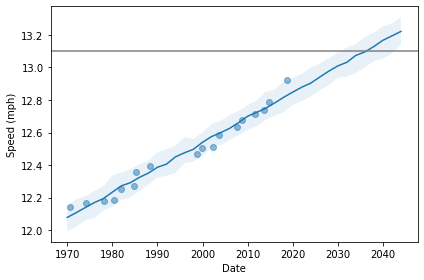

In [129]:
times = pd.to_timedelta(xs*365.24, unit='days') + offset

plt.fill_between(times, low, high, alpha=0.1)
plt.plot(times, median, color='C0')

plot_speeds(data)

In [130]:
from scipy.interpolate import interp1d

future = np.array([interp1d(high, xs)(13.1),
                   interp1d(median, xs)(13.1),
                   interp1d(low, xs)(13.1)])

pd.to_timedelta(future*365.24, unit='day') + offset

DatetimeIndex(['2030-07-30 08:12:22.004294400',
               '2036-04-10 23:13:15.326140800',
               '2042-07-06 19:04:32.009606400'],
              dtype='datetime64[ns]', freq=None)

## Summary


## Exercises


**Exercise:** I am under the impression that it is warmer around here than it used to be.  In this exercise, you can put my conjecture to the test.

We'll use the same dataset we used to model changes in snowfall, which also includes daily low and high temperatures in Norfolk County, Massachusetts during my lifetime.

Here's the data.

In [203]:
df = pd.read_csv('2239075.csv', parse_dates=[2])
df.head(3)

,STATION,NAME,DATE,PRCP,SNOW,SNWD,TMAX,TMIN,TOBS,WESD,WT01,WT03,WT04,WT05,WT06,WT08,WT09,WT11,WT16,WT18
0,USC00190736,"BLUE HILL COOP, MA US",1967-05-11,0.43,0.0,0.0,57,36.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,USC00190736,"BLUE HILL COOP, MA US",1967-05-12,0.00,0.0,0.0,58,39.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,USC00190736,"BLUE HILL COOP, MA US",1967-05-13,0.00,0.0,0.0,64,38.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Again, I'll create a column that contains the year part of the dates.

In [204]:
df['YEAR'] = df['DATE'].dt.year

This dataset includes `TMIN` and `TMAX`, which are the daily low and high temperatures in degrees F.
I'll create a new column with the daily midpoint of the low and high temperatures.

In [205]:
df['TMID'] = (df['TMIN'] + df['TMAX']) / 2

Now we can group by year and compute the mean of these daily temperatures.

In [206]:
tmid = df.groupby('YEAR')['TMID'].mean()
len(tmid)

54

Again, I'll drop the first and last years, which are incomplete.

In [207]:
complete = tmid.iloc[1:-1]
len(complete)

52

Here's what the time series looks like.

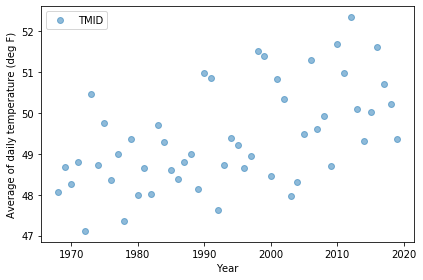

In [208]:
complete.plot(style='o', alpha=0.5)

decorate(xlabel='Year',
         ylabel='Annual average of daily temperature (deg F)')

As we did with the snow data, I'll convert the `Series` to a `DataFrame` to prepare it for regression.

In [209]:
data = complete.reset_index()
data.head()

,YEAR,TMID
0,1968,48.071038
1,1969,48.687671
2,1970,48.258904
3,1971,48.804110
4,1972,47.112022


In [210]:
offset = data['YEAR'].mean()
offset

1993.5

In [211]:
data['x'] = data['YEAR'] - offset
data['x'].mean()

0.0

In [213]:
data['y'] = data['TMID']
data['y'].std()

1.2389114009625752

Now we can use StatsModels to estimate the parameters.

In [214]:
import statsmodels.formula.api as smf

formula = 'y ~ x'
results = smf.ols(formula, data=data).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.293
Model:                            OLS   Adj. R-squared:                  0.279
Method:                 Least Squares   F-statistic:                     20.72
Date:                Fri, 21 Aug 2020   Prob (F-statistic):           3.42e-05
Time:                        13:10:46   Log-Likelihood:                -75.405
No. Observations:                  52   AIC:                             154.8
Df Residuals:                      50   BIC:                             158.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     49.4080      0.146    338.652      0.000      49.115      49.701
x              0.0443      0.010      4.552      0.000       0.025       0.064
==============================================================================
Omnibus:                        2.748   Durbin-Watson:                   2.055
Prob(Omnibus):                  0.253   Jarque-Bera (JB):                2.116
Skew:                           0.340   Prob(JB):                        0.347
Kurtosis:                       2.283   Cond. No.                         15.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

According to the least squares regression model, annual average temperature is increasing by about 0.044 degrees F per year.

To quantify the uncertainty of this model and generate predictions for the future, we can use Bayesian regression to estimate the parameters.

1. Choose priors for `slope`, `intercept`, and `sigma` based on these estimates, and use `make_joint3` to make a joint prior distribution.

2. Use `update_regression` to compute the posterior distribution of the parameters.

3. Use `pmf_marginal` to extract the posterior distribution of `slope`.  How confident are we that temperature is increasing?

4. Draw a sample of parameters from the posterior distribution and use it to generate predictions up to 2067.

5. Plot the median of the predictions and a 90% credible interval along with the observed data.  

Does the model fit the data well?  How much do we expect annual average temperatures to increase over my (expected) lifetime?



In [161]:
# Solution

slopes = np.linspace(0, 0.1, 51)
prior_slope = Pmf(1, slopes)
prior_slope.index.name = 'Slope'

In [162]:
# Solution

inters = np.linspace(48, 52, 41)
prior_inter = Pmf(1, inters)
prior_inter.index.name = 'Intercept'

In [163]:
# Solution

sigmas = np.linspace(0.5, 2, 31)
prior_sigma = Pmf(1, sigmas)
prior_sigma.index.name = 'Sigma'

In [164]:
# Solution

prior3 = make_joint3(prior_slope, prior_inter, prior_sigma)
prior3.head()

Slope  Intercept  Sigma
0.0    48.0       0.50     1
                  0.55     1
                  0.60     1
                  0.65     1
                  0.70     1
dtype: int64

In [165]:
# Solution

%time posterior = update_regression(prior3, data)
posterior.head()

CPU times: user 51.4 s, sys: 0 ns, total: 51.4 s
Wall time: 51.5 s


Slope  Intercept  Sigma
0.0    48.0       0.50     4.350393e-133
                  0.55     6.983527e-108
                  0.60      4.864592e-89
                  0.65      1.182812e-74
                  0.70      1.771567e-63
dtype: float64

In [166]:
# Solution

from utils import pmf_marginal

posterior_sigma = pmf_marginal(posterior, 2)

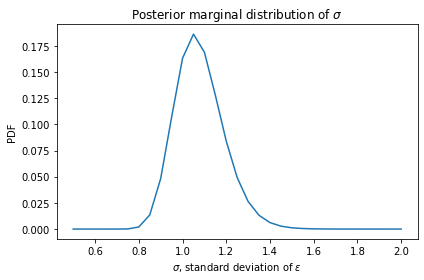

In [167]:
# Solution

posterior_sigma.plot()

decorate(xlabel='$\sigma$, standard deviation of $\epsilon$',
         ylabel='PDF',
         title='Posterior marginal distribution of $\sigma$')

In [168]:
# Solution

posterior_slope = pmf_marginal(posterior, 0)
posterior_inter = pmf_marginal(posterior, 1)

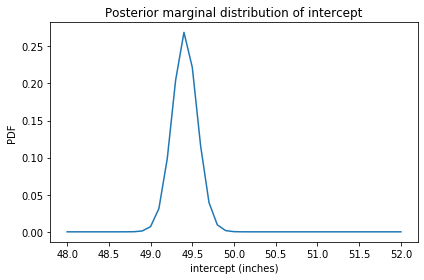

In [169]:
# Solution

posterior_inter.plot()
decorate(xlabel='intercept (inches)',
         ylabel='PDF',
         title='Posterior marginal distribution of intercept')

In [170]:
# Solution

posterior_inter.mean(), posterior_inter.credible_interval(0.9)

(49.40873454799849, array([49.2, 49.7]))

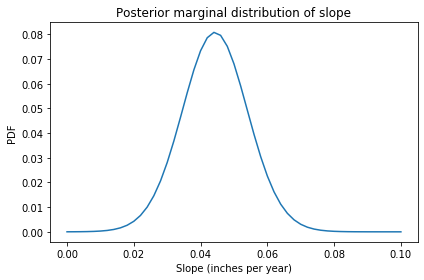

In [171]:
# Solution

posterior_slope.plot()
decorate(xlabel='Slope (inches per year)',
         ylabel='PDF',
         title='Posterior marginal distribution of slope')

In [172]:
# Solution

posterior_slope.mean(), posterior_slope.credible_interval(0.9)

(0.04428821242606907, array([0.028, 0.06 ]))

In [218]:
# Solution

sample = posterior.sample(101)

years = np.arange(1967, 2067, 2)
xs = years - offset

pred = np.empty((len(sample), len(xs)))
for i, (slope, inter, sigma) in enumerate(sample):
    pred[i] = inter + slope * xs + norm(0, sigma).rvs(len(xs))
    
pred.shape

(101, 50)

In [219]:
# Solution

low, median, high = np.percentile(pred, [5, 50, 95], axis=0)
median.shape

(50,)

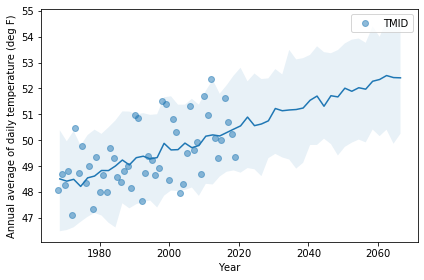

In [220]:
# Solution

plt.fill_between(times, low, high, alpha=0.1)
plt.plot(times, median, color='C0')

complete.plot(style='o', alpha=0.5)

decorate(xlabel='Year',
         ylabel='Annual average of daily temperature (deg F)')

## GSS data

Another example using data from the [General Social Survey](https://gss.norc.org/) ...


In [37]:
# Load the data file

# TODO: Update this to point to the ThinkBayes2 repo

import os

datafile = 'gss_eda.hdf5'
if not os.path.exists(datafile):
    !wget https://github.com/AllenDowney/PoliticalAlignmentCaseStudy/raw/master/gss_eda.hdf5

In [38]:
gss = pd.read_hdf(datafile, 'gss')
gss.shape

(64814, 169)

In [40]:
gss.groupby('year')['realrinc'].max()

year
1972              NaN
1973              NaN
1974     96450.000000
1975     75863.000000
1976     81652.000000
1977    201640.000000
1978    135131.000000
1980    139297.000000
1982     97992.000000
1983     81266.000000
1984     87058.000000
1985     96036.000000
1986    101376.000000
1987     92594.000000
1988     83666.000000
1989     80690.000000
1990    103206.000000
1991    111284.000000
1993    123611.000000
1994     97684.000000
1996     87419.000000
1998    150054.000000
2000    134018.000000
2002    234366.656250
2004    134008.437500
2006    159292.265625
2008    480144.468750
2010    109525.156250
2012    341672.375000
2014    132148.078125
2016    164382.031250
2018    151050.718750
Name: realrinc, dtype: float32

In [41]:
gss['rincome'].value_counts()

12.0    14957
9.0      4876
11.0     3838
10.0     3838
2.0      1865
8.0      1745
1.0      1306
3.0      1243
5.0      1091
4.0      1055
6.0       993
7.0       981
Name: rincome, dtype: int64

In [42]:
valid = gss.dropna(subset=['rincome', 'realinc'])
valid.shape

(36916, 169)

2000


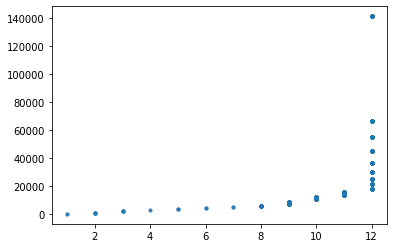

In [50]:
for name, group in valid.groupby('year'):
    if name == 2000:
        print(name)
        plt.plot(group['income'], group['realinc'], '.', alpha=0.3)

In [ ]:
valid = gss.dropna(subset=['realinc', 'polviews'])
valid.shape

In [ ]:
plt.plot(valid['realinc'], valid['polviews'], ',', alpha=0.3)